In [ ]:
import os
from dotenv import load_dotenv
from sqlalchemy import create_engine
import pandas as pd
import re

# LangChain & LangGraph
from langchain_community.utilities import SQLDatabase
from langchain.chains import create_sql_query_chain
from langchain_openai import AzureChatOpenAI
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool
from langgraph.graph import StateGraph

In [ ]:
# Load environment variables and establish a connection to the SQL database
load_dotenv()
connectionString = os.environ["py-connectionString"]
db_engine = create_engine(connectionString)

# LLM setup using Azure OpenAI and AI Foundry
llm = AzureChatOpenAI(
    azure_deployment=os.environ["AZURE_OPENAI_DEPLOYMENT_NAME"],
    azure_endpoint=os.environ["AZURE_OPENAI_ENDPOINT"],
    api_key=os.environ["AZURE_OPENAI_API_KEY"],
    api_version=os.environ.get("AZURE_OPENAI_API_VERSION", "2024-12-01-preview"),
    temperature=0,
)

# Define a function for SQL connection and query execution
db = SQLDatabase(db_engine)
execute_query = QuerySQLDatabaseTool(db=db)
write_query = create_sql_query_chain(llm, db)



In [ ]:
# Function to retrieve schema information from the database
def get_schema_info():
    query = """
    SELECT [table_schema], [table_name], [column_name], [data_type], [description]
    FROM [ExecutiveDashboard].[dbo].[schema_metadata]
    """
    df = pd.read_sql(query, db_engine)
    prompt_lines = []
    for (schema, table), group in df.groupby(['table_schema', 'table_name']):
        prompt_lines.append(f"Table: {table} (schema: {schema})")
        prompt_lines.append("Columns:")
        for _, row in group.iterrows():
            prompt_lines.append(f"  - {row['column_name']} ({row['data_type']}): {row['description']}")
        prompt_lines.append("")
    return "\n".join(prompt_lines)

# Function to extract SQL from text
def extract_sql(text):
    match = re.search(r"```sql\s*(.*?)```", text, re.DOTALL | re.IGNORECASE)
    if match:
        return match.group(1).strip()
    match = re.search(r"(SELECT[\s\S]+?;)", text, re.IGNORECASE)
    if match:
        return match.group(1).strip()
    return text.strip()

# Retrieve schema information and clean it up
custom_schema_info = get_schema_info()
custom_schema_info = re.sub(r'\n\s*\n', '\n', custom_schema_info).strip()

# Define the system prompt for the LLM
# This prompt includes the schema information and the rules for generating SQL queries
# It is designed to ensure that the LLM generates queries that are syntactically correct, efficient, and safe for SQL Server 2019.
system_prompt = (
    "You are an expert T-SQL assistant for Microsoft SQL Server 2019 (version 15.0.4261.1). "
    "Your job is to help users by generating correct, efficient, and safe T-SQL queries based ONLY on the schema and relationship information provided below. "
    "Strictly follow these rules:\n"
    "1. Use ONLY the tables, columns, and relationships described in the schema and relationships section. Do NOT assume the existence of any other tables, columns, or relationships.\n"
    "2. For every SQL query you generate, ALWAYS use the '(NOLOCK)' table hint after every table name in the FROM and JOIN clauses to avoid locking.\n"
    "3. Write queries that are syntactically correct for SQL Server and optimized for readability and performance.\n"
    "4. If a question cannot be answered using ONLY the provided schema and relationships, clearly state that the answer cannot be determined from the available information.\n"
    "5. Do NOT use features or syntax not supported by SQL Server 2019.\n"
    "6. Do NOT include any explanations, comments, or extra text in your SQL output—return only the SQL code in a code block.\n"
    "7. If aggregation, filtering, or sorting is required, use the appropriate T-SQL constructs.\n"
    "8. If a question is ambiguous, make the safest assumption based on the schema and relationships and state your assumption before the query.\n"
    "9. If the question is not clear, ask for clarification before generating a query.\n"
    

    "\n"
    "SCHEMA INFORMATION:\n"
    f"{custom_schema_info}\n"
    "RELATIONSHIPS:\n"
    "- Customer Paid for Orders: DailySales_Raw.Payee refers to V_CustomerStatus.CustomerID (many Orders per Customer) if PayeeType is C.\n"
    "- Distributor Paid for Orders: DailySales_Raw.Payee refers to V_DistributorStatus.DistributorID (many Orders per Distributor) if PayeeType is D.\n"
    "- Product Detail: DailySales_Raw.ProductCode refers to Products.ProductID (many Products (SKU) per Order)\n"
    
)

In [ ]:
from pydantic import BaseModel
from typing import Optional, Any  # Add Any
import pandas as pd

# Define the AgentState model
# This model represents the state of the agent, including the question, schema information, SQL code, result, and other relevant fields.
class AgentState(BaseModel):
    question: str
    schema_info: Optional[str] = None
    sql_code: Optional[str] = None
    result: Optional[Any] = None
    is_valid: bool = True
    answer: Optional[str] = None
    is_relevant: bool = True
    last_node: Optional[str] = None
    retry_count: int = 0
    feedback: Optional[str] = None
    chart_type: Optional[str] = None
    viz_code: Optional[str] = None
    viz_image: Optional[str] = None  # base64 PNG string
    viz_reason: Optional[str] = None


In [ ]:

# Set this to limit how many times you retry failed queries.
MAX_RETRIES = 2

# Add last_node and retry_count tracking in all nodes:
# Check relevance node
# This node checks if the user's question is relevant to the data warehouse.
def check_relevance_node(state: AgentState) -> AgentState:
    state.last_node = "check_relevance"
    relevance_prompt = (
        "You are a data warehouse assistant. "
        "Is the following user question about sales, revenue, orders, products, distributors, or customers in the data warehouse? "
        "Answer only 'yes' or 'no'.\n\n"
        f"Question: {state.question}"
    )
    response = llm.invoke(relevance_prompt)
    answer = response.content.strip().lower() if hasattr(response, "content") else str(response).strip().lower()
    if answer.startswith("yes"):
        state.is_relevant = True
    else:
        state.is_relevant = False
        state.answer = (
            "Sorry, I cannot answer this question as it is not related to orders, products, distributors, or customers in the data warehouse."
        )
    return state

# Get schema information node
# This node retrieves the schema information from the database and stores it in the state.
def get_schema_node(state: AgentState) -> AgentState:
    state.last_node = "get_schema"
    state.schema_info = custom_schema_info
    return state

# Build query node
# This node generates an SQL query based on the user's question and the schema information.
def build_query_node(state: AgentState) -> AgentState:
    state.last_node = "build_query"
    question = state.question
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": question}
    ]
    # Add feedback if present (for retries)
    feedback = getattr(state, "feedback", None)
    if feedback:
        messages.append({"role": "system", "content": f"Feedback from last attempt: {feedback}"})
        del state.feedback  # Reset feedback after use
    sql_query = llm.invoke(messages)
    sql_code = extract_sql(sql_query.content if hasattr(sql_query, "content") else sql_query)
    state.sql_code = sql_code
    return state

# Execute query node
# This node executes the generated SQL query and stores the result in the state.
def execute_query_node(state):
    state.last_node = "execute_query"
    sql_code = state.sql_code
    try:
        df = pd.read_sql(sql_code, db_engine)
        state.result = df
    except Exception as e:
        state.result = str(e)
    return state

# Validate node
# This node checks if the SQL query execution was successful and updates the state accordingly.
def validate_node(state):
    state.last_node = "validate"
    result_str = str(state.result)
    error_detected = any(word in result_str.lower() for word in [
        "error", "exception", "traceback", "incorrect syntax", "invalid column", "failed", "invalid object", "does not exist"
    ])
    state.is_valid = not error_detected
    return state

# Retry query node
# This node handles retries for failed SQL queries, generating a corrected query based on the error message
def retry_query_node(state: AgentState) -> AgentState:
    state.last_node = "retry_query"
    # Count retries
    state.retry_count = getattr(state, "retry_count", 0) + 1
    if state.is_valid:
        return state  # No error, skip retry

    result_str = str(state.result)
    correction_prompt = (
        f"The following SQL query failed to execute:\n"
        f"{state.sql_code}\n\n"
        f"Error message:\n{result_str}\n\n"
        "Based ONLY on the schema below, please generate a corrected SQL query. "
        "Do not explain, just provide the corrected SQL in a code block.\n\n"
        f"{state.schema_info}"
    )
    correction = llm.invoke(correction_prompt)
    corrected_sql = extract_sql(correction.content if hasattr(correction, "content") else correction)
    state.sql_code = corrected_sql
    state.feedback = f"Previous SQL failed with: {result_str}"
    result = execute_query.invoke({"query": corrected_sql})
    state.result = result

    # Validate again after retry
    result_str = str(state.result)
    error_detected = any(word in result_str.lower() for word in [
        "error", "exception", "traceback", "incorrect syntax", "invalid column", "failed", "invalid object", "does not exist"
    ])
    state.is_valid = not error_detected
    return state

# Explain result node
# This node generates a clear, concise, and well-formatted answer to the user's question based on the SQL result.
def explain_result_node(state):
    state.last_node = "explain_result"
    result_str = str(state.result)
    followup_prompt = (
        f"Question: {state.question}\n"
        f"SQL Query Executed:\n{state.sql_code}\n"
        f"SQL Result:\n{result_str}\n\n"
        "Please provide a clear, concise, and well-formatted answer to the question based on the SQL result above."
    )
    answer = llm.invoke(followup_prompt)
    state.answer = answer.content if hasattr(answer, "content") else answer
    return state


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import base64
import io
import traceback

# Analyze and generate visualization node
# This node analyzes the SQL result and generates a visualization if possible.
def analyze_and_generate_visualization_node(state: AgentState) -> AgentState:
    state.last_node = "analyze_visualization"
    df = state.result if isinstance(state.result, pd.DataFrame) else None

    if df is None or df.empty:
        state.viz_reason = "The SQL result is empty or not tabular data, so a chart cannot be generated."
        state.chart_type = None
        return state

    # Improved prompt
    data_sample = df.head(5).to_csv(index=False)
    data_columns = ", ".join([f"{col} ({df[col].dtype})" for col in df.columns])

    viz_prompt = f"""
        You are a data visualization expert and Python programmer.

        Given:
        - The user's question: "{state.question}"
        - The SQL result as a pandas DataFrame called df (already loaded in memory, do not use pd.read_csv or any file I/O).
        - The DataFrame has columns: {data_columns}
        - Here are the first rows:
        {data_sample}

        Use the columns EXACTLY as shown above—do not make up or rename columns.

        1. Decide if a meaningful chart can be generated from df.
        2. If yes, reply with ONLY valid Python code (using pandas and matplotlib) to generate the best chart (bar, line, pie, etc.) from df, using the columns above.
        3. Save the chart as a PNG to the buffer 'buf'.
        4. Do not display or show the plot. Do not add extra text, comments, markdown, or file I/O.
        5. If a chart is NOT possible or not meaningful, reply ONLY with "#NOCHART reason" on a single line, and do NOT output any Python code or else: blocks containing #NOCHART.

        Only output valid Python code using the provided DataFrame variable 'df', or #NOCHART.
        """

    response = llm.invoke(viz_prompt)
    llm_output = response.content if hasattr(response, "content") else str(response)
    llm_output = llm_output.strip()

    # Remove markdown code block fencing if present
    def strip_markdown_code_blocks(text):
        import re
        text = text.strip()
        if text.startswith("```"):
            text = re.sub(r"^```[\w]*\n?", "", text)
            text = re.sub(r"\n?```$", "", text)
        return text.strip()
    
    llm_output = strip_markdown_code_blocks(llm_output)

    # Skip execution if #NOCHART is anywhere in the response
    if "#NOCHART" in llm_output:
        state.viz_reason = llm_output.replace("#NOCHART", "").strip()
        state.chart_type = None
        state.viz_code = None
        state.viz_image = None
        return state

    # Remove any 'else:' blocks with #NOCHART for safety
    llm_output = re.sub(r'else\s*:\s*\n\s*#NOCHART.*', '', llm_output, flags=re.DOTALL|re.IGNORECASE)

    state.viz_code = llm_output

    buf = io.BytesIO()
    local_vars = {"df": df, "plt": plt, "io": io, "buf": buf}

    try:
        # Execute LLM code (which might overwrite buf)
        exec(state.viz_code, {}, local_vars)
        # Find the buffer object actually used
        buf_obj = local_vars.get('buf', None)
        # If buf_obj is None, try to find any BytesIO object used in local_vars
        if buf_obj is None or not hasattr(buf_obj, 'getvalue'):
            for v in local_vars.values():
                if isinstance(v, io.BytesIO):
                    buf_obj = v
                    break
        if buf_obj is None:
            raise Exception("No buffer object found after running chart code")
        buf_obj.seek(0)
        img_bytes = buf_obj.read()
        print("Bytes in generated image:", len(img_bytes))  # Debug print; remove if you like
        if not img_bytes:
            raise Exception("Chart code ran but buffer is empty!")
        state.viz_image = base64.b64encode(img_bytes).decode('utf-8')
        state.chart_type = "LLM-generated"
    except Exception as e:
        print("Error while generating chart:", e)
        print(traceback.format_exc())
        state.viz_image = None
        state.viz_reason = f"Error running chart code: {e}\n{traceback.format_exc()}"

    return state


In [ ]:
from langgraph.graph import StateGraph,START, END

# Create the state graph and add nodes
graph = StateGraph(AgentState)
graph.add_node("check_relevance", check_relevance_node)
graph.add_node("get_schema", get_schema_node)
graph.add_node("build_query", build_query_node)
graph.add_node("execute_query", execute_query_node)
graph.add_node("validate", validate_node)
graph.add_node("retry_query", retry_query_node)
graph.add_node("explain_result", explain_result_node)
graph.add_node("analyze_visualization", analyze_and_generate_visualization_node)

graph.add_edge(START, "check_relevance")

graph.add_conditional_edges(
    "check_relevance",
    lambda state: "get_schema" if state.is_relevant else END
)
graph.add_edge("get_schema", "build_query")
graph.add_edge("build_query", "execute_query")
graph.add_edge("execute_query", "validate")
# Conditional edge: validate -> retry_query (if not valid), else explain_result
graph.add_conditional_edges(
    "validate",
    lambda state: "retry_query" if not state.is_valid else "explain_result"
)


# Conditional edge: retry_query -> build_query (if still not valid & retries left), else explain_result
def retry_logic(state):
    state.retry_count = getattr(state, "retry_count", 0) + 1
    if state.is_valid:
        return "explain_result"
    elif state.retry_count < 2:   # or your MAX_RETRIES
        return "build_query"
    else:
        state.answer = "Failed after maximum retries."
        return "explain_result"
    
graph.add_conditional_edges("retry_query", retry_logic)
graph.add_edge("explain_result", "analyze_visualization")
graph.add_edge("analyze_visualization", END)

runnable = graph.compile()


#### Flow

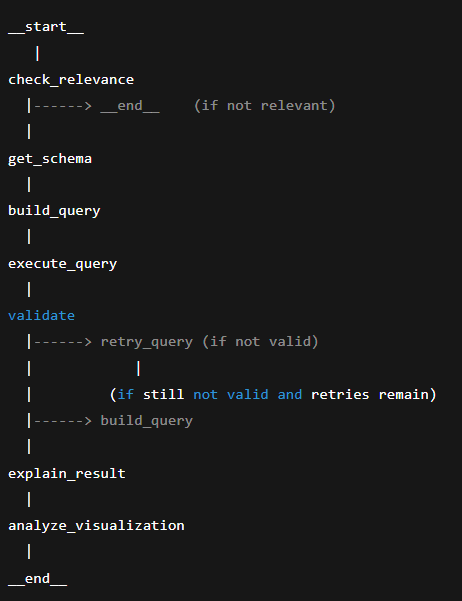

###

In [ ]:
# Run the SQL assistant with a question
# This function initializes the agent state with the user's question and runs the state graph to get the final answer.
# It returns the answer, SQL code, and the final state of the agent.
def run_sql_assistant(question):
    initial_state = {"question": question}
    final_state = runnable.invoke(initial_state)
    # Optionally check 'is_relevant'
    if final_state.get("is_relevant", True):  # If missing, assume relevant
        answer = final_state.get("answer", "")
        sql_code = final_state.get("sql_code", "")
    else:
        answer = final_state.get("answer", "Sorry, your question was not relevant to the data warehouse.")
        sql_code = ""
    return answer, sql_code, final_state

In [ ]:
# Example usage of the SQL assistant
# Uncomment the line below to run a specific query
answer, sql_code, final_state = run_sql_assistant(
  # "Total sale of SKU: T14506 month over month in 2025"
   #'What's the capital on USA ?"
   "Top 10 distributor  by sales in may 2025"
   #"How many active distributors by country. exclude country = none. "
   #"Give me top 10 Order source  by total sales for site country = USA for 2025."
   #"based on sales data , give me top 5 Country by Total Sales in 2025. show me the data with with percentage."
)
print("LLM Answer:\n", answer)
print("SQL Query Executed:\n", sql_code)

if final_state.get("viz_image"):
    from IPython.display import Image
    import base64
    display(Image(data=base64.b64decode(final_state["viz_image"])))
elif final_state.get("viz_reason"):
    print("No chart generated:", final_state["viz_reason"])

